## Is it a bear?

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
%pip install -U duckduckgo_search
%pip install fastai
%pip install fastbook

     |████████████████████████████████| 97 kB 3.1 MB/s             
     |████████████████████████████████| 75 kB 2.8 MB/s             
     |████████████████████████████████| 7.3 MB 50.5 MB/s            
     |████████████████████████████████| 74 kB 2.5 MB/s             
     |████████████████████████████████| 57 kB 4.0 MB/s             
     |████████████████████████████████| 2.8 MB 58.1 MB/s            
  Attempting uninstall: lxml
    Found existing installation: lxml 4.8.0
    Uninstalling lxml-4.8.0:
      Successfully uninstalled lxml-4.8.0
  Attempting uninstall: click
    Found existing installation: click 8.0.3
    Uninstalling click-8.0.3:
      Successfully uninstalled click-8.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
spacy 3.2.3 requires typing-extensions<4.0.0.0,>=3.7.4; py

## Step 1: Download images of bear and forest

In [3]:
from fastbook import *
from fastai.vision.widgets import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images=max_images))


In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bear photos', max_images=1)
urls[0]

Searching for 'bear photos'


'https://thelatebloomerhiker.files.wordpress.com/2014/11/grizzly-bear-22224-1920x1200.jpg'

...and then download a URL and take a look at it:

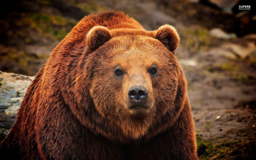

In [5]:
from fastdownload import download_url
dest = 'bear.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photos'


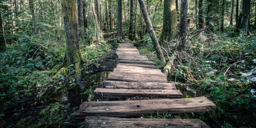

In [6]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [7]:
searches = 'forest','bear'
path = Path('bear_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bear photo'
Searching for 'bear sun photo'
Searching for 'bear shade photo'


In [8]:
print(path)
searches = 'forest','bear'

for imageType in searches:
    print(imageType)
    content = os.listdir(path/imageType)
    for element in content:
        print(element)

bear_or_not
forest
b7743515-ba68-41d1-9548-aa4d64c4a287.jpg
8e9ac7b1-6d5f-4a8b-884f-532165729473.jpg
6c42bc3e-47f1-4942-8959-82f3f022aa59.jpg
d2a0dfdb-fea3-4df4-aa18-048ca2dab6aa.jpg
c9ebefea-dcc7-452d-ae8e-6301f307c00c.jpg
5b35e776-0605-460e-985a-7788343bfe53.jpg
b235b9d0-b480-4e24-b35e-78f561598fb6.jpg
f7b77edc-622f-474a-8e65-ee601286b7e6.jpg
8c01b113-1317-4b9f-82cc-7146e13e4c0d.jpg
295ec2b8-22cb-4bf2-b2de-704821aff5ae.png
700b67a5-3d3a-40d9-a243-488df9f7dc14.jpg
0ae423a8-960f-4e2a-85b7-4267909720e7.jpg
101bcfab-8e71-4a8b-b0b4-bdd0dd03cae1.jpg
a50e3b8d-5ada-410d-b10a-ec2be2776304.jpg
67977cab-9590-4f17-a386-52e20de9a4c0.jpg
980414a1-d75e-49e8-b19d-07bc00060f1a.jpg
a504e7be-d211-467d-8b29-f732bb08fa11.jpg
ac0454fb-6cab-466c-9cbc-1ea797c29316.jpg
f921c18c-cb67-422e-96fc-f5be7bbbdffb.jpg
bf46bfc8-b146-4a65-b997-feb34659f781.jpg
502af555-8de7-43d9-9c4f-ba9f38e6e631.jpg
9a265acc-3a2f-405f-8a4f-fca90a64f0f1.jpg
7a7bb3c0-3634-497b-ac11-6a53ca10495c.jpg
a743e9d2-86e0-4896-85a7-7d4e870457ba.j

## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

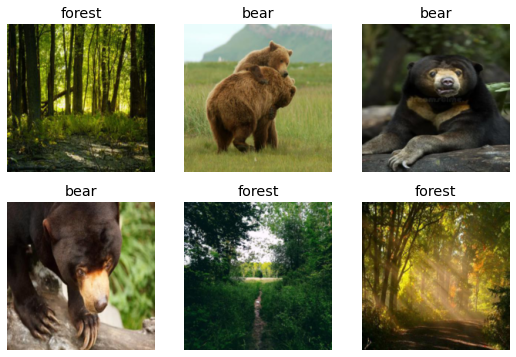

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.156071,0.830563,0.303030,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.129867,0.076584,0.030303,00:01
1,0.077106,0.007975,0.000000,00:01
2,0.051296,0.003715,0.000000,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

In [12]:
learn.export("model.pkl")

This is a: bear.
Probability it's a bear: 1.0000
